In [1]:
!source activate pytorch

In [2]:
import yaml
import json
import torch
from torch.utils.data import Dataset
from torch import nn
import plotly.express as px
from ignite.contrib.metrics import ROC_AUC, PrecisionRecallCurve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import string

In [3]:
class Vocab:
    def __init__(self, tokens): 
        special_tokens = ["PAD", "SOS", "EOS"]
        self.tokens = tokens + special_tokens
        self.token_ix = {t:i for i, t in enumerate(self.tokens)}
        self.ix_token = {i:t for i,t in enumerate(self.tokens)}

    def encode(self, seq, max_len=None):
        encoded = [self.token_ix["SOS"]] + [self.token_ix[t] for t in seq] + [self.token_ix["EOS"]]
        if max_len:
            if len(encoded) < max_len:
                encoded += [self.token_ix["PAD"]]*(max_len-len(encoded))
                
        return encoded
                
    def decode(self, seq):
        return [self.ix_token[t] for t in seq]

    def __len__(self):
        return len(self.tokens)

class ProteinVocab(Vocab):
    def __init__(self):
        # 20 amino acids
        tokens = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'X']
        super().__init__(tokens)
        
class SMILEVocab(Vocab):
    def __init__(self):
        tokens = []
        tokens += list(string.digits) 
        tokens += list(string.ascii_letters)
        tokens += list(string.punctuation)
        tokens += [" "]
        
        super().__init__(tokens)

In [4]:
# models/pretraining.py

class GRUModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1, dropout=0, bidirectional=False):
        super().__init__()
        
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.bidirectional = bidirectional
        
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True, bidirectional=bidirectional)
        self.out = nn.Linear(hidden_size*2 if self.bidirectional else hidden_size, vocab_size)
        
        
    def forward(self, x, hidden=None):
        x = self.embedding(x)
        x, hidden = self.gru(x, hidden)
        x = self.out(x[:, -1])
        return x, hidden

In [5]:
## models/transformer.py

class PositionalEncoding(nn.Module):
    """Sinusoidal Positional Encoding
    """
    def __init__(self, d_model, max_len):
        super().__init__()
        self.d_model = d_model
        self.max_len = max_len
        
        positions = torch.arange(0, max_len).unsqueeze(1)

        frequencies = 10000**(torch.arange(0, d_model, 2)/d_model)
        
        self.encoding = torch.zeros(max_len, d_model)

        self.encoding[:, 1::2] = torch.sin(positions / frequencies)
        self.encoding[:, 0::2] = torch.cos(positions / frequencies)

    def forward(self, x):
        seq_len = x.shape[1]

        x = x  + self.encoding[:seq_len].to(x.device)

        return x


class CrossLayer(nn.Module):
    def __init__(self, embed_size, n_head, hidden_size, dropout):
        super().__init__()
        self.embed_size = embed_size
        self.n_head = n_head
        self.hidden_size = hidden_size
        self.dropout = dropout

        self.self_attention_encoder_1 = nn.TransformerEncoderLayer(
            d_model=embed_size,
            nhead=n_head,
            dim_feedforward=hidden_size,
            dropout=dropout,
            batch_first=True
        )

        self.self_attention_encoder_2 = nn.TransformerEncoderLayer(
            d_model=embed_size,
            nhead=n_head,
            dim_feedforward=hidden_size,
            dropout=dropout,
            batch_first=True
        )

        self.cross_attention1 = nn.MultiheadAttention(embed_dim=embed_size, num_heads=n_head, batch_first=True)
        self.cross_attention2 = nn.MultiheadAttention(embed_dim=embed_size, num_heads=n_head, batch_first=True)


    def forward(self, x1, x2):

        # x1 -> (N, S)
        # x2 -> (N, S)

        cross_alignment_1, _ = self.cross_attention1(
            query=x2,
            key=x1,
            value=x1
        )

        cross_alignment_2, _ = self.cross_attention2(
            query=x1,
            key=x2,
            value=x2
        )

        alignment_1 = self.self_attention_encoder_1(cross_alignment_1)
        alignment_2 = self.self_attention_encoder_2(cross_alignment_2)

        return alignment_1, alignment_2


class CrossNet(nn.Module):
    def __init__(self, hidden_size, n_head, num_layers, dropout, mode="classification"):
        super().__init__()

        self.hidden_size = hidden_size
        self.n_head = n_head
        self.num_layers = num_layers
        self.dropout = dropout
        self.is_contrastive = mode=="contrastive"

        self.drug_embedding = None
        self.protein_embedding = None

        self.cross_layers = nn.ModuleList([
            CrossLayer(embed_size=64, n_head=n_head, hidden_size=hidden_size, dropout=dropout) for _ in range(num_layers)
        ])

        if not self.is_contrastive:
            self.out = nn.Linear(64*2, 2)


        self.positional_encoding = PositionalEncoding(d_model=64, max_len=20000)


    def set_drug_protein_embeddings(self, drug, protein):
        self.drug_embedding = drug
        self.protein_embedding = protein

        self.drug_embedding.requires_grad = False
        self.protein_embedding.requires_grad = False


    def forward(self, x):
        x1, x2 = x
        N = x1.shape[0]

        x1 = self.drug_embedding(x1) # (N, S, E)
        x2 = self.protein_embedding(x2) # (N, S, E)

        x1 = self.positional_encoding(x1)
        x2 = self.positional_encoding(x2)

        for layer in self.cross_layers:
            x1, x2 = layer(x1, x2)


        # x1 (N, S, 64)
        # x2 (N, S, 64)

        x1 = x1.mean(1) # (N, 64)
        x2 = x2.mean(1) # (N, 64)

        if self.is_contrastive: 
            return x1, x2
        
        else:
            x = torch.cat([x1, x2], 1) # (N, 64*2)
            x = self.out(x)

            return x


class Transformer(nn.Module):
    def __init__(self, hidden_size, n_head, num_layers, dropout, mode=None):
        super().__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout

        self.drug_embedding = None
        self.protein_embedding = None

        self.transformer = nn.Transformer(
            d_model=64,
            nhead=n_head,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=hidden_size,
            dropout=dropout,
            batch_first=True,
        )

        self.positional_encoding = PositionalEncoding(d_model=64, max_len=20000)

        self.out = nn.Linear(64, 2)


    def set_drug_protein_embeddings(self, drug, protein):
        self.drug_embedding = drug
        self.protein_embedding = protein

        self.drug_embedding.requires_grad = False
        self.protein_embedding.requires_grad = False


    def forward(self, x):
        x1, x2 = x
        
        N = x1.shape[0]

        x1 = self.drug_embedding(x1) # (N, S, E)
        x2 = self.protein_embedding(x2) # (N, S, E)

        x1 = self.positional_encoding(x1)
        x2 = self.positional_encoding(x2)

        x = self.transformer(x1, x2)

        x = x.mean(1)

        out = self.out(x)
        
        return out


def build(name, config):
    hidden_size = config["HIDDEN_SIZE"]
    num_layers = config["NUM_LAYERS"]
    dropout = config["DROPOUT"]
    num_heads = config["NUM_HEADS"]
    mode = "contrastive" if bool(config["CONTRASTIVE"]) else "classification"

    
    if "cross" in name:
        net = CrossNet(hidden_size=hidden_size, n_head=num_heads, num_layers=num_layers, dropout=dropout, mode=mode)

    else:
        net = Transformer(hidden_size=hidden_size, n_head=num_heads, num_layers=num_layers, dropout=dropout)

    return net
    

In [6]:
amino_vocab = ProteinVocab()
smile_vocab = SMILEVocab()

In [7]:
pretrained_smile_embeddings = GRUModel(
    vocab_size=len(smile_vocab),
    embed_size=64,
    hidden_size=128,
    num_layers=1,
    dropout=0,
    bidirectional=False
)

pretrained_amino_embeddings = GRUModel(
    vocab_size=len(amino_vocab),
    embed_size=64,
    hidden_size=128,
    num_layers=1,
    dropout=0,
    bidirectional=False
)

pretrained_smile_embeddings.load_state_dict(torch.load("../checkpoints/pretraining/smile_gru.pth"))
pretrained_amino_embeddings.load_state_dict(torch.load("../checkpoints/pretraining/protein_gru.pth"))

pretrained_smile_embeddings = pretrained_smile_embeddings.embedding
pretrained_amino_embeddings = pretrained_amino_embeddings.embedding

In [8]:
transformer_config = yaml.safe_load(open("../config/transformer/transformer_classification_baseline.yml", "r"))
cross_alignet_config = yaml.safe_load(open("../config/transformer/crosstransformer_contrastive_baseline.yml", "r"))

In [9]:
transformer = build("transformer", transformer_config)
cross_alignet = build("cross", cross_alignet_config)

transformer.set_drug_protein_embeddings(
    pretrained_smile_embeddings,
    pretrained_amino_embeddings
)

cross_alignet.set_drug_protein_embeddings(
    pretrained_smile_embeddings,
    pretrained_amino_embeddings
)

In [10]:
transformer_checkpoint = torch.load("../checkpoints/classification/transformer-classification-baseline/model.pt", map_location="cpu")
cross_alignet_checkpoint = torch.load("../checkpoints/classification/crosstransformer-contrastive-baseline/model.pt", map_location="cpu")

transformer_state_dict = transformer_checkpoint["model"]
cross_alignet_state_dict = cross_alignet_checkpoint["model"]

print(f"Test Accuracy (Transformer) @ (epoch {transformer_checkpoint['epoch']:3}) -> {transformer_checkpoint['accuracy']}")
print(f"Test Accuracy (Cross-AlNet) @ (epoch {cross_alignet_checkpoint['epoch']:3}) -> {cross_alignet_checkpoint['accuracy']}")


transformer.load_state_dict(transformer_state_dict)
cross_alignet.load_state_dict(cross_alignet_state_dict)

transformer.eval()
cross_alignet.eval()

transformer.requires_grad_(False)
cross_alignet.requires_grad_(False)

Test Accuracy (Transformer) @ (epoch  96) -> 0.9633423089981079
Test Accuracy (Cross-AlNet) @ (epoch  31) -> 0.7601252198219299


CrossNet(
  (cross_layers): ModuleList(
    (0-1): 2 x CrossLayer(
      (self_attention_encoder_1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (self_attention_encoder_2): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
       

In [11]:
import pandas as pd

class DTIDataset(Dataset):
    def __init__(self, train, smile_vocab, protein_vocab, smile_embedding, amino_embedding, device="cuda"):
        self.device = device
        if train:
            self.df = pd.read_csv("../data/combined_train.csv")
        else:
            self.df = pd.read_csv("../data/combined_test.csv")

        self.df.dropna(inplace=True)

        self.train = train
        self.smile_vocab = smile_vocab
        self.protein_vocab = protein_vocab
        self.smile_embedding = smile_embedding
        self.amino_embedding = amino_embedding

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        drug = row["Drug"]
        target = row["Target"]
        y = row["Y"]
        
        drug = torch.Tensor(self.smile_vocab.encode(drug)).long().to(self.device) # get tokenized
        # drug = self.smile_embedding(drug).mean(1).squeeze() # get embeddings
        
        target = torch.Tensor(self.protein_vocab.encode(target)).long().to(self.device) # get tokenized
        # target = self.amino_embedding(target).mean(1).squeeze() # get embeddings
        

        drug = drug.to(self.device)
        target = target.to(self.device)[:3000] # the amino acids sequences are usually unreasonably long. So we truncate for feasible processing times.
        
        return drug, target, y

In [12]:
test = DTIDataset(
    train=False,
    smile_vocab=smile_vocab,
    protein_vocab=amino_vocab,
    smile_embedding=pretrained_smile_embeddings,
    amino_embedding=pretrained_amino_embeddings,
    device="cuda"
)

In [13]:
def get_predictions_from_similarity(repr1, repr2, thresh=.5):
    repr1 = torch.nn.functional.normalize(repr1, p=2, dim=1) # l2 norm
    repr2 = torch.nn.functional.normalize(repr2, p=2, dim=1) # l2 norm 
    distance = torch.abs(torch.nn.functional.cosine_similarity(repr1, repr2)) # (N)
    
    pred = (distance > thresh).long()

    return pred, distance

In [14]:
# utils.py

def dataloader_collate_fn(data):
    """
    Pad (x1, x2) in data to same length in batch
    """

    x1, x2, y = zip(*data)

    y = torch.Tensor(list(y))

    lengths_x1 = [len(x) for x in x1]
    lengths_x2 = [len(x) for x in x2]

    max_len_x1 = max(lengths_x1)
    max_len_x2 = max(lengths_x2)

    batch_size = len(lengths_x1)

    x1_padded = torch.zeros(batch_size, max_len_x1).fill_(51)
    x2_padded = torch.zeros(batch_size, max_len_x2).fill_(21) # 21 is the <PAD> token in the amino acids vocab

    for i, seq in enumerate(x1):
        end = lengths_x1[i]
        x1_padded[i, :end] = seq[:end]

    for i, seq in enumerate(x2):
        end = lengths_x2[i]
        x2_padded[i, :end] = seq[:end]


    x1_padded = x1_padded.long()
    x2_padded = x2_padded.long()


    return x1_padded, x2_padded, y

In [21]:
train = DTIDataset(
    train=True,
    smile_vocab=smile_vocab,
    protein_vocab=amino_vocab,
    smile_embedding=pretrained_smile_embeddings,
    amino_embedding=pretrained_amino_embeddings,
    device="cuda"
)

In [16]:
dataloader = torch.utils.data.DataLoader(train, batch_size=16, collate_fn=dataloader_collate_fn)

In [17]:
from tqdm import tqdm

In [18]:
t=1

In [22]:
roc_auc = ROC_AUC()

transformer.to("cuda")
transformer.eval()

with torch.no_grad():
    for x1, x2, y in tqdm(dataloader):
        x1 = x1.to("cuda")
        x2 = x2.to("cuda")
        y = y.to("cuda")

        p = transformer((x1, x2)).softmax(-1).softmax(-1) # (N, 2)
        p = p[:, 1] # get prob of being 1
        roc_auc.update((p, y))

#             y_pred.append(p)
#             y_true.append(y)

roc_auc_value = roc_auc.compute()

print(f"temperature : {t} | roc-auc : {roc_auc_value}")

# y_pred = torch.cat(y_pred, dim=0)
# y_true = torch.cat(y_true, dim=0)

# fpr, tpr, thresholds = roc_curve(y_true.cpu().numpy(), y_pred.cpu().numpy())

# print(roc_auc_value)

# plt.plot(fpr, tpr)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve (AUC = {:.2f})'.format(roc_auc_value))
# plt.show()

100%|██████████| 4356/4356 [02:13<00:00, 32.62it/s]

temperature : 1 | roc-auc : 0.6508857560273018


0.5046062967987186


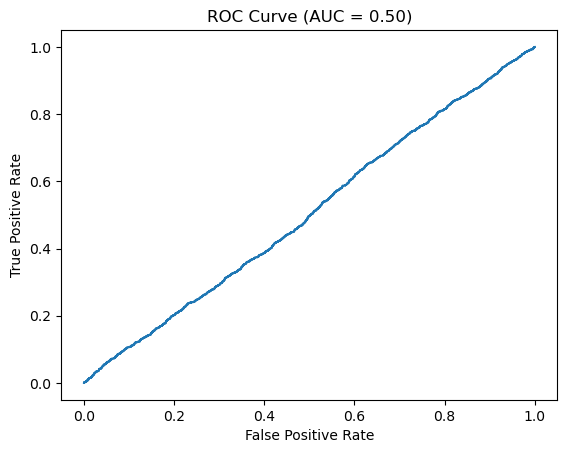

In [26]:
roc_auc = ROC_AUC()

y_pred = []
y_true = []

cross_alignet.to("cuda")

with torch.no_grad():
    for x1, x2, y in dataloader:
        x1 = x1.to("cuda")
        x2 = x2.to("cuda")
        y = y.to("cuda")
        
        _,distance = get_predictions_from_similarity(*cross_alignet((x1, x2)))
        p = distance
        roc_auc.update((p, y))
        
        y_pred.append(p)
        y_true.append(y)
        
roc_auc_value = roc_auc.compute()

y_pred = torch.cat(y_pred, dim=0)
y_true = torch.cat(y_true, dim=0)

fpr, tpr, thresholds = roc_curve(y_true.cpu().numpy(), y_pred.cpu().numpy())

print(roc_auc_value)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (AUC = {:.2f})'.format(roc_auc_value))
plt.show()

In [46]:
pr_auc = PrecisionRecallCurve()

y_pred = []
y_true = []

transformer.to("cuda")

with torch.no_grad():
    for x1, x2, y in dataloader:
        x1 = x1.to("cuda")
        x2 = x2.to("cuda")
        y = y.to("cuda")
        
        p = transformer((x1, x2)).softmax(-1) # (N, 2)
        p = p[:, 1] # get prob of being 1
        pr_auc.update((p, y))
        
        y_pred.append(p)
        y_true.append(y)
        
pr_auc_value = pr_auc.compute()

y_pred = torch.cat(y_pred, dim=0)
y_true = torch.cat(y_true, dim=0)

# fpr, tpr, thresholds = roc_curve(y_true.cpu().numpy(), y_pred.cpu().numpy())

print(pr_auc_value.shape)

# plt.plot(fpr, tpr)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve (AUC = {:.2f})'.format(roc_auc_value))
# plt.show()

(tensor([0.4965, 0.4966, 0.4967,  ..., 1.0000, 1.0000, 1.0000],
       dtype=torch.float64), tensor([1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 6.6511e-04, 3.3256e-04,
        0.0000e+00], dtype=torch.float64), tensor([7.0084e-04, 7.7141e-04, 8.1354e-04,  ..., 9.7198e-01, 9.8021e-01,
        9.8236e-01]))


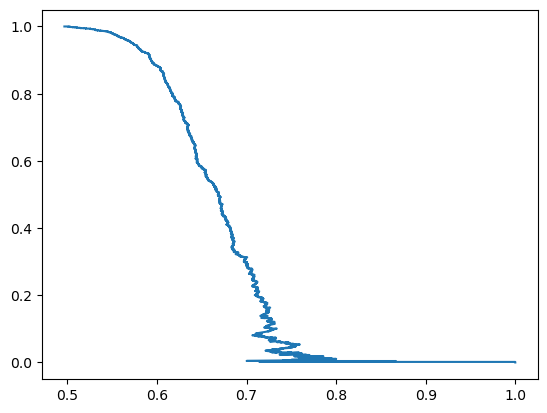

In [55]:
plt.plot(pr_auc_value[0].cpu().numpy(), pr_auc_value[1].cpu().numpy())

In [51]:
from sklearn.metrics import auc


In [53]:
auc(pr_auc_value[1].cpu().numpy(), pr_auc_value[0].cpu().numpy())

0.663323388894805